In [1]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

2024-06-02 19:19:05.551062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 19:19:05.551193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 19:19:05.684412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1556 files belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


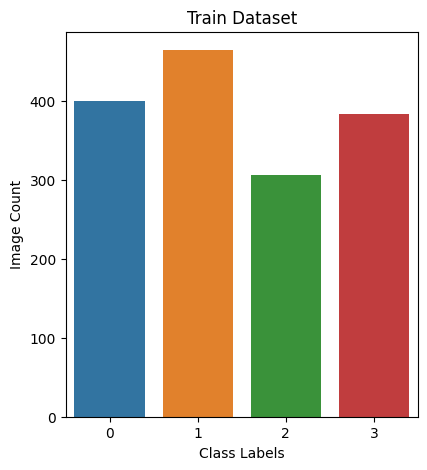

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Loading train and val datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/almond-varieties/dataset",
    image_size=(224, 224),
    batch_size=32
)

# Collecting class labels
train_labels = []
for _, labels in train_dataset:
    train_labels.extend(labels.numpy())

# Counting occurrences of each label
train_label_counts = Counter(train_labels)

# Plotting the counts
plt.figure(figsize=(10, 5))

# Train dataset
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_label_counts.keys()), y=list(train_label_counts.values()))
plt.title('Train Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')
plt.show()

In [6]:
# Loading train and val datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/almond-varieties/dataset",
    image_size=(224, 224),
    batch_size=32
)

# Normalizing datasets
normalization_layer = keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

# Converting the datasets to lists of images and labels
train_images = []
train_labels = []
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        train_images.append(image.numpy())
        train_labels.append(label.numpy())

# Converting to arrays
images = np.array(train_images)
labels = np.array(train_labels)

# Converting labels to probability distributions
labels = keras.utils.to_categorical(labels, 4)

Found 1556 files belonging to 4 classes.


In [7]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (933, 224, 224, 3)
y_train: (933, 4)
x_test: (311, 224, 224, 3)
y_test: (311, 4)
x_val: (312, 224, 224, 3)
y_val: (312, 4)


0


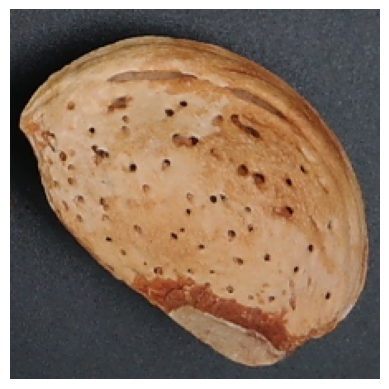

In [9]:
# plotting images with label as probability distribution

plt.imshow(train_images[600]) 
plt.axis('off')
print(train_labels[600])

1


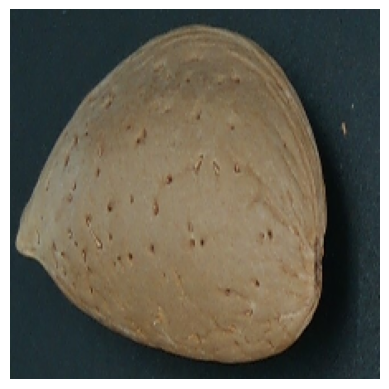

In [11]:
plt.imshow(train_images[800]) 
plt.axis('off')
print(train_labels[800])

2


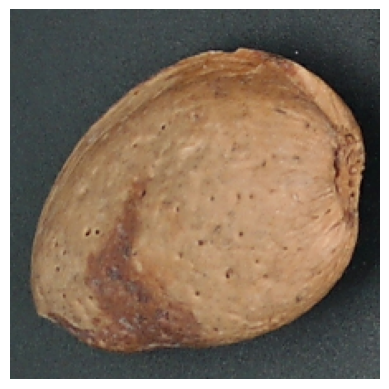

In [10]:
plt.imshow(train_images[1200]) 
plt.axis('off')
print(train_labels[1200])

3


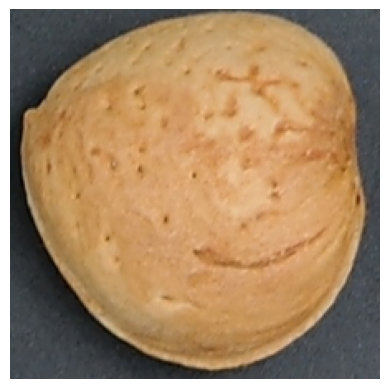

In [12]:
plt.imshow(train_images[400]) 
plt.axis('off')
print(train_labels[400])

In [13]:
import gc # calling garbage collector to reduce memory utilization

del train_dataset

gc.collect()

9693

In [14]:
from keras import mixed_precision # changing precision policies
mixed_precision.set_global_policy('mixed_float16')

In [15]:
tf.config.optimizer.set_jit(True) # setting optimizer to reduce model computation by optimizing graph-computations

### VGG16

In [16]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# Loading model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary() # printing summary of model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,164,676 (31.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5435 - loss: 1.4679
Epoch 1: val_accuracy improved from -inf to 0.94551, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.5454 - loss: 1.4614 - val_accuracy: 0.9455 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9245 - loss: 0.2411
Epoch 2: val_accuracy did not improve from 0.94551
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9245 - loss: 0.2410 - val_accuracy: 0.9327 - val_loss: 0.2066 - learning_rate: 0.0010
Epoch 3/20
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9309 - loss: 0.2009
Epoch 3: val_accuracy did not improve from 0.94551
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9312 - loss: 0.2004 - val_accuracy: 0.9391 - val_loss: 0.1965 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9470 - loss: 0.1540
Epoch 4: val_accuracy improved from 0.94551 to 0.94872,

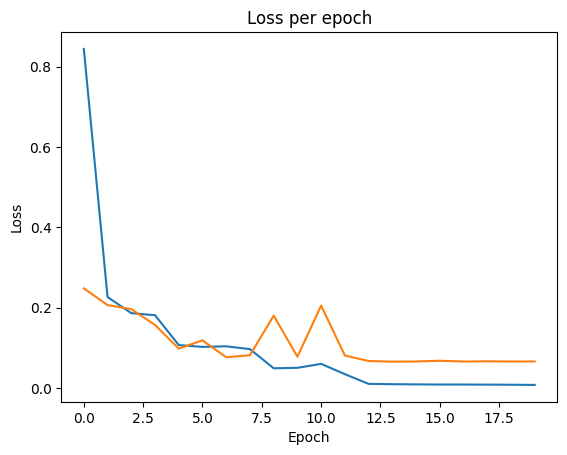

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

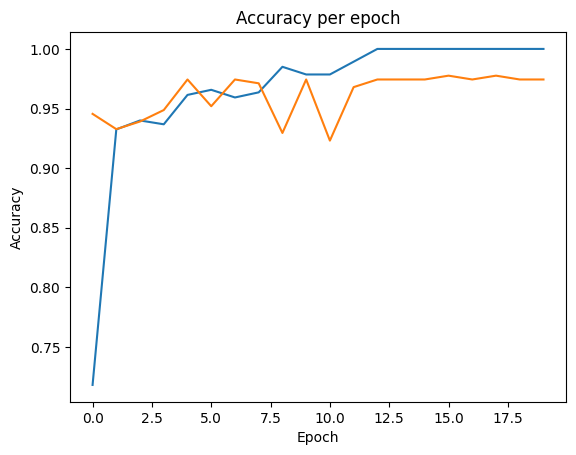

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### ResNet50

In [22]:
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv4_block3_out').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

# Setting callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 210,749,828 (803.95 MB)

 Trainable params: 205,526,020 (784.02 MB)

 Non-trainable params: 5,223,808 (19.93 MB)

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/94 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.1500 - loss: 2.6416  

W0000 00:00:1717356360.106971     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2480 - loss: 10.6791

W0000 00:00:1717356372.483253     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717356376.220617     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.29808, saving model to model.keras


W0000 00:00:1717356381.349246     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 401ms/step - accuracy: 0.2484 - loss: 10.6833 - val_accuracy: 0.2981 - val_loss: 11.3137 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3002 - loss: 11.2800
Epoch 2: val_accuracy did not improve from 0.29808
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.3001 - loss: 11.2804 - val_accuracy: 0.2981 - val_loss: 11.3137 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3170 - loss: 11.0086
Epoch 3: val_accuracy did not improve from 0.29808
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3168 - loss: 11.0119 - val_accuracy: 0.2981 - val_loss: 11.3137 - learning_rate: 0.0010
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2860 - loss: 11.5084
Epoch 4: val_accuracy did not improve from 0.29808
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.2861 - loss: 11.5064 - val_accuracy: 0.2981 - val_loss: 11.3137 - learning_rate: 0.0010
Epoch 5/20
94/94 ━━

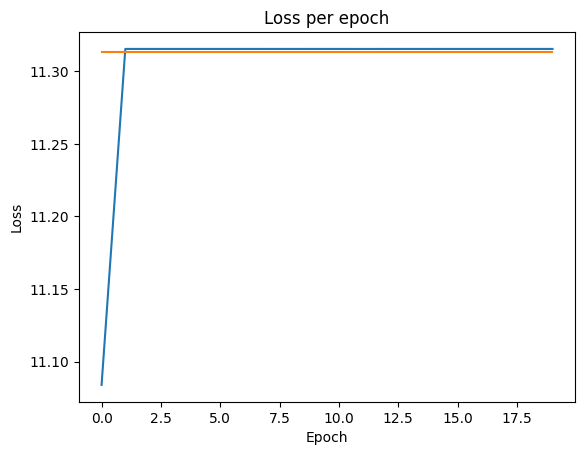

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

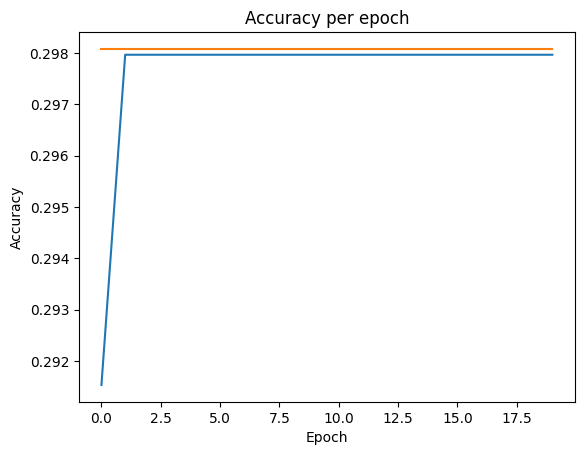

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [29]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet121_model.input, outputs=densenet121_model.get_layer('conv5_block6_concat').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False
    
# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 6,266,308 (23.90 MB)

 Trainable params: 726,020 (2.77 MB)

 Non-trainable params: 5,540,288 (21.13 MB)

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5920 - loss: 1.0541
Epoch 1: val_accuracy improved from -inf to 0.95513, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 75s 477ms/step - accuracy: 0.5938 - loss: 1.0511 - val_accuracy: 0.9551 - val_loss: 0.3060 - learning_rate: 0.0010
Epoch 2/20
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9477 - loss: 0.2619
Epoch 2: val_accuracy did not improve from 0.95513
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9482 - loss: 0.2599 - val_accuracy: 0.9551 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 3/20
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9822 - loss: 0.1057
Epoch 3: val_accuracy improved from 0.95513 to 0.95833, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9822 - loss: 0.1056 - val_accuracy: 0.9583 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 4/20
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9896 - loss: 0.0647
Epoch 4: val_accuracy

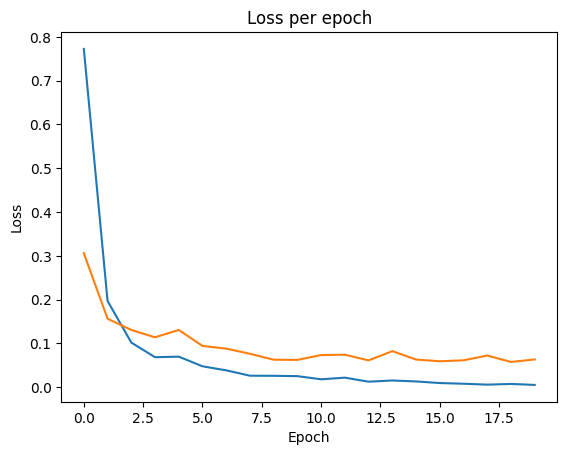

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

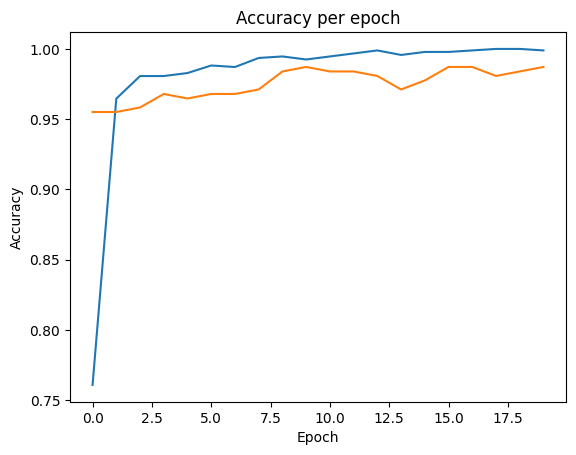

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [33]:
from keras.applications import Xception
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,963,756 (87.60 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6079 - loss: 1.8533
Epoch 1: val_accuracy improved from -inf to 0.92949, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 193ms/step - accuracy: 0.6095 - loss: 1.8443 - val_accuracy: 0.9295 - val_loss: 0.2185 - learning_rate: 0.0010
Epoch 2/20
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9371 - loss: 0.1665
Epoch 2: val_accuracy did not improve from 0.92949
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9374 - loss: 0.1658 - val_accuracy: 0.9295 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 3/20
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9830 - loss: 0.0646
Epoch 3: val_accuracy improved from 0.92949 to 0.94551, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9828 - loss: 0.0649 - val_accuracy: 0.9455 - val_loss: 0.1630 - learning_rate: 0.0010
Epoch 4/20
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9847 - loss: 0.0510
Epoch 4: val_accuracy 

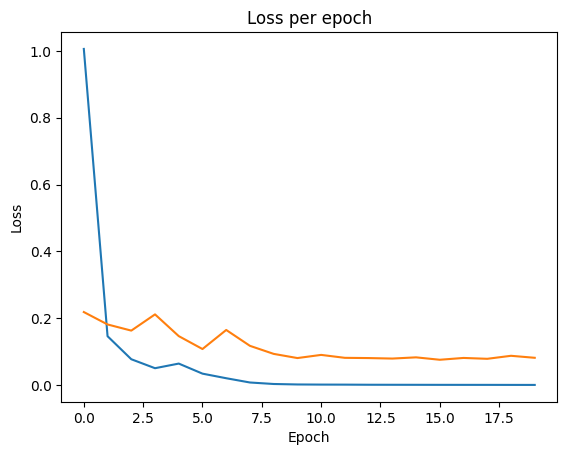

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

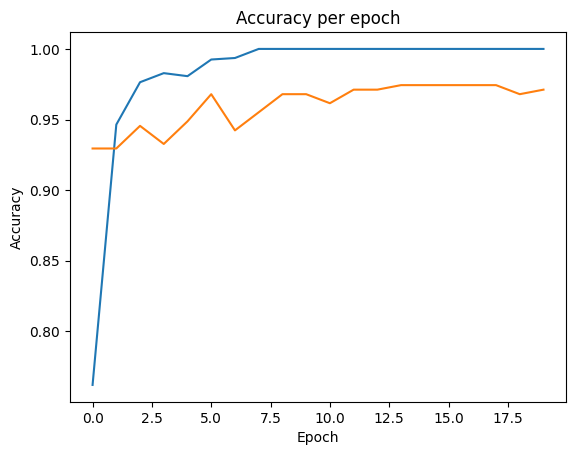

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception

In [37]:
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 111, 111,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4489 - loss: 4.1385
Epoch 1: val_accuracy improved from -inf to 0.74359, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 360ms/step - accuracy: 0.4504 - loss: 4.1362 - val_accuracy: 0.7436 - val_loss: 3.4895 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7611 - loss: 3.1480
Epoch 2: val_accuracy improved from 0.74359 to 0.75000, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7610 - loss: 3.1499 - val_accuracy: 0.7500 - val_loss: 3.5080 - learning_rate: 0.0010
Epoch 3/20
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8151 - loss: 2.7729
Epoch 3: val_accuracy improved from 0.75000 to 0.75321, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8137 - loss: 2.7930 - val_accuracy: 0.7532 - val_loss: 3.4098 - learning_rate: 0.0010
Epoch 4/20
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8011 - l

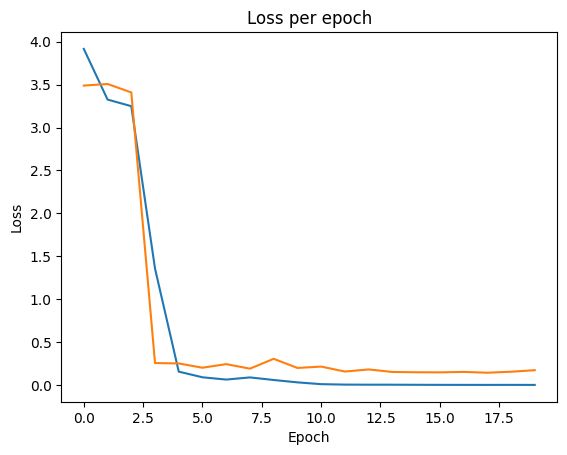

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

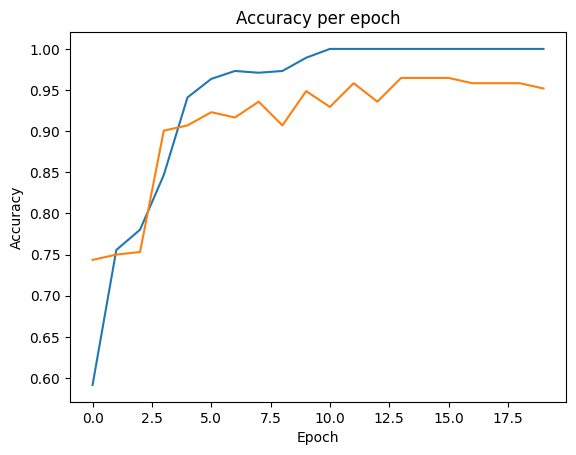

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### EfficientNetB7

In [41]:
from keras.applications import EfficientNetB7
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=efficientnet_model.input, outputs=efficientnet_model.get_layer('top_activation').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 66,724,251 (254.53 MB)

 Trainable params: 2,626,564 (10.02 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2645 - loss: 1.8415  
Epoch 1: val_accuracy improved from -inf to 0.29808, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.2645 - loss: 1.8390 - val_accuracy: 0.2981 - val_loss: 1.3967 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2679 - loss: 1.4149
Epoch 2: val_accuracy did not improve from 0.29808
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.2678 - loss: 1.4150 - val_accuracy: 0.2724 - val_loss: 1.3832 - learning_rate: 0.0010
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2637 - loss: 1.3935
Epoch 3: val_accuracy did not improve from 0.29808
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.2638 - loss: 1.3935 - val_accuracy: 0.2981 - val_loss: 1.4168 - learning_rate: 0.0010
Epoch 4/20
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2895 - loss: 1.3938
Epoch 4: val_accuracy did not improve from 0.29808
94/94 

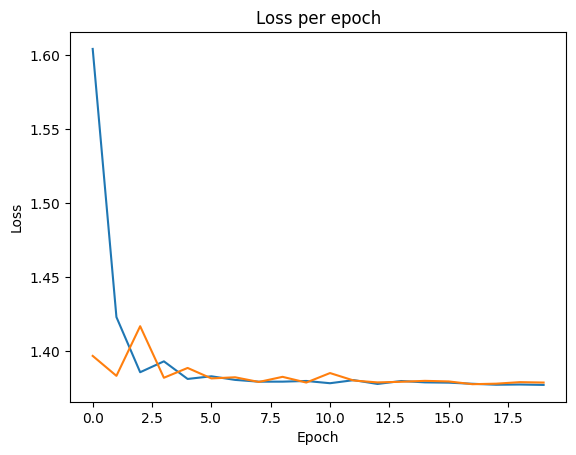

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

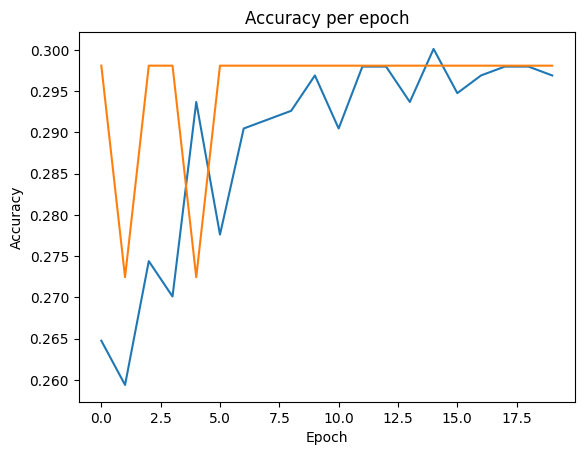

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN

In [69]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, InputLayer
from keras.regularizers import l1_l2

model = Sequential()

model.add(InputLayer(shape=(224, 224, 3))) # input layer

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same',kernel_regularizer=l1_l2(0.0001,0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D()) # pooling down

model.add(Dense(1024, activation='relu')) # dense layer

model.add(Dense(4, activation='softmax')) # output layer

model.summary() # model summary

# model checkpoint callback
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_122 (Conv2D)             │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_124         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,260 (719.77 KB)

 Trainable params: 183,748 (717.77 KB)

 Non-trainable params: 512 (2.00 KB)

In [70]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=10,callbacks=[model_checkpoint])

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7082 - loss: 0.8979
Epoch 1: val_accuracy improved from -inf to 0.20513, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.7092 - loss: 0.8957 - val_accuracy: 0.2051 - val_loss: 5.7971
Epoch 2/30
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8460 - loss: 0.5326
Epoch 2: val_accuracy did not improve from 0.20513
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8472 - loss: 0.5289 - val_accuracy: 0.2051 - val_loss: 6.2152
Epoch 3/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8970 - loss: 0.4193
Epoch 3: val_accuracy improved from 0.20513 to 0.27244, saving model to model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8971 - loss: 0.4188 - val_accuracy: 0.2724 - val_loss: 4.6928
Epoch 4/30
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8726 - loss: 0.4724
Epoch 4: val_accuracy did not improve from 0.27244
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - ac

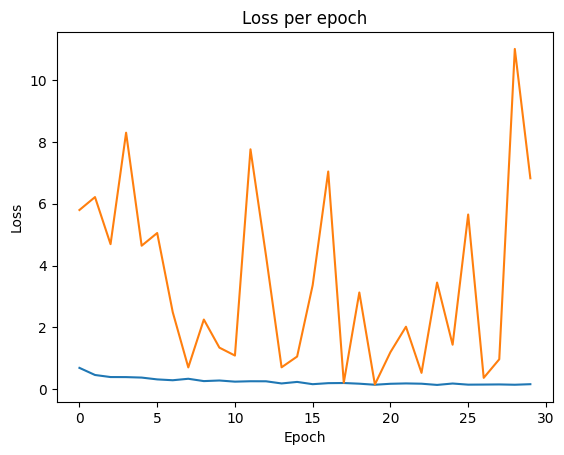

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

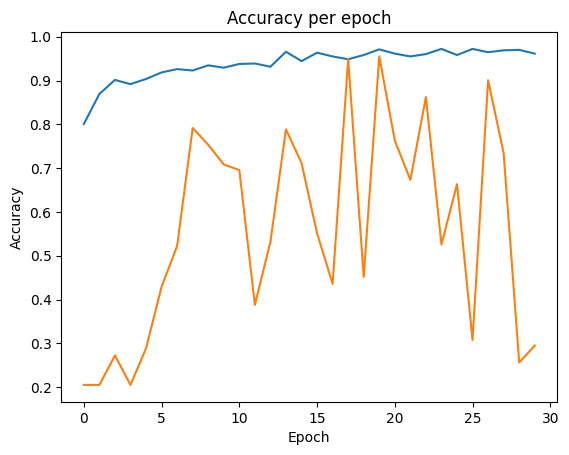

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()